<a href="https://colab.research.google.com/github/dmunozbe/TFM_DataScience/blob/main/Forecasting/08.%20Nou%20Barris/Forecasting_(Indicador_79).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecasting**


1. [Importar bibliotecas](#Importar-bibliotecas)
2. [Carga de datos](#Carga-de-datos)
3. [Preparacion de los datos](#Preparacion-de-los-datos)
4. [Analisis por grupo de indicadores (Motorizacion Turismos)](#Analisis-por-grupo-de-indicadores-(-motorizacion))
  - [Preparacion de datos](#Preparacion-de-datos)
  - [Analisis Exploratorio](#Analisis-Exploratorio)
  - [Modelo VAR](#Modelo-VAR)
  - [Modelo VARMAX](#Modelo-VARMAX)
5. [Conclusiones](#Conclusiones)



**Forecasting** es el proceso de predecir eventos futuros basados en patrones históricos y datos existentes.

El objetivo principal es el de hacer predicciones precisas sobre el futuro utilizando datos pasados y presentes y se utiliza en una amplia variaedad de constextos, como en finanzas, meteorologia, ventas entre otros

##Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import metrics


import warnings
warnings.filterwarnings("ignore")

##Carga de datos

In [2]:
# Cargar datos
data = pd.read_csv('/content/drive/MyDrive/UOC/TFM/Datasets definitivos/Final.csv')
data.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,ParadosReg,Estudios_Obligatorios,ConsumResidencial,Pm25,Pm10,Participacion,AñosEspVida,Internet,Movil,Index_Turisme,m² por habitante
0,2014,1,1,1,Ciutat Vella,1,el Raval,2813.0,4588,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
1,2014,1,2,1,Ciutat Vella,1,el Raval,2813.0,4539,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
2,2014,1,3,1,Ciutat Vella,1,el Raval,2813.0,4572,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
3,2014,2,4,1,Ciutat Vella,1,el Raval,2948.8,4510,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2
4,2014,2,5,1,Ciutat Vella,1,el Raval,2948.8,4379,NaN,NaN,NaN,NaN,41.8,80.7,NaN,NaN,NaN,6.2


In [3]:
print(data.dtypes)

Any                        int64
Trimestre                  int64
Mes                        int64
Codi_Districte             int64
Nom_Districte             object
Codi_Barri                 int64
Nom_Barri                 object
Compraventa_Unitario     float64
ParadosReg                 int64
Estudios_Obligatorios    float64
ConsumResidencial        float64
Pm25                     float64
Pm10                     float64
Participacion            float64
AñosEspVida              float64
Internet                 float64
Movil                    float64
Index_Turisme            float64
m² por habitante         float64
dtype: object


## Analisis por grupo de indicadores (Motorizacion Turismos)

### Preparacion de datos

In [4]:
df_sel = data[['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri','Compraventa_Unitario','Index_Turisme']]

In [5]:
df_cont = df_sel.dropna()

In [6]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2628 entries, 4380 to 7007
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Any                   2628 non-null   int64  
 1   Trimestre             2628 non-null   int64  
 2   Mes                   2628 non-null   int64  
 3   Codi_Districte        2628 non-null   int64  
 4   Nom_Districte         2628 non-null   object 
 5   Codi_Barri            2628 non-null   int64  
 6   Nom_Barri             2628 non-null   object 
 7   Compraventa_Unitario  2628 non-null   float64
 8   Index_Turisme         2628 non-null   float64
dtypes: float64(2), int64(5), object(2)
memory usage: 205.3+ KB


In [7]:
# Creamos la variable de fecha de la siguiente manera:
# Agregar un día fijo para cada mes, por ejemplo, el día 1
df_cont['Fecha'] = pd.to_datetime(df_cont['Any'].astype(str) + '-' + df_cont['Mes'].astype(str) + '-1')

In [8]:
# Modificamos el indice del dataset por la fecha
df_contI = df_cont.set_index('Fecha')

In [9]:
df_contI.head()

,Any,Trimestre,Mes,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri,Compraventa_Unitario,Index_Turisme
Fecha,,,,,,,,,
2019-01-01,2019,1,1,1,Ciutat Vella,1,el Raval,3775.1,122.718571
2019-02-01,2019,1,2,1,Ciutat Vella,1,el Raval,3775.1,122.718571
2019-03-01,2019,1,3,1,Ciutat Vella,1,el Raval,3775.1,122.718571
2019-04-01,2019,2,4,1,Ciutat Vella,1,el Raval,3838.4,122.718571
2019-05-01,2019,2,5,1,Ciutat Vella,1,el Raval,3838.4,122.718571


### Analisis Exploratorio

Filtramos los datos por el distrito de Nou Barris -> Codi_Districte = 8

In [10]:
df_contFiltrado = df_contI[df_contI['Codi_Districte'] == 8]

In [11]:
# Agrupamos los datos
df =df_contFiltrado.drop(columns=['Any','Trimestre','Mes','Codi_Districte','Nom_Districte','Codi_Barri','Nom_Barri']).groupby('Fecha').mean()

In [12]:
df.head()

,Compraventa_Unitario,Index_Turisme
Fecha,,
2019-01-01,2242.453846,280.495356
2019-02-01,2242.453846,280.495356
2019-03-01,2242.453846,280.495356
2019-04-01,2145.500000,280.495356
2019-05-01,2145.500000,280.495356


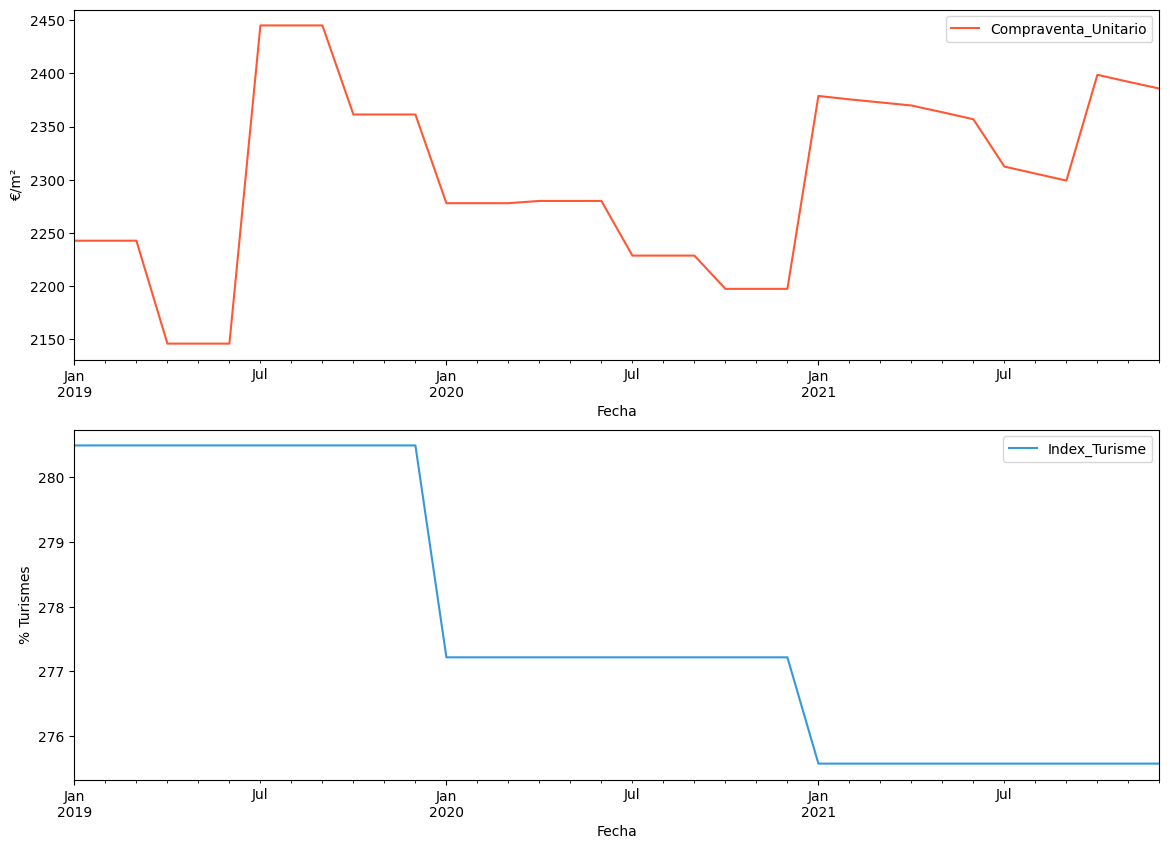

In [13]:
fig, axes = plt.subplots(nrows = int(len(df.columns)), ncols = 1, dpi = 100, figsize = (14,10))
unidades = ['€/m²', '% Turismes' ]
colores = ['#FF5733', '#3498DB']

for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df[col].plot(color = colores[i], legend = True, ax = ax)
    ax.set_ylabel(unidades[i])  # Establecer etiqueta del eje y
plt.show()

Cada una de las series tiene patrones de tendencia muy diferentes entre si

In [14]:
corr=df.corr()
corr

,Compraventa_Unitario,Index_Turisme
Compraventa_Unitario,1.00000,-0.19876
Index_Turisme,-0.19876,1.00000


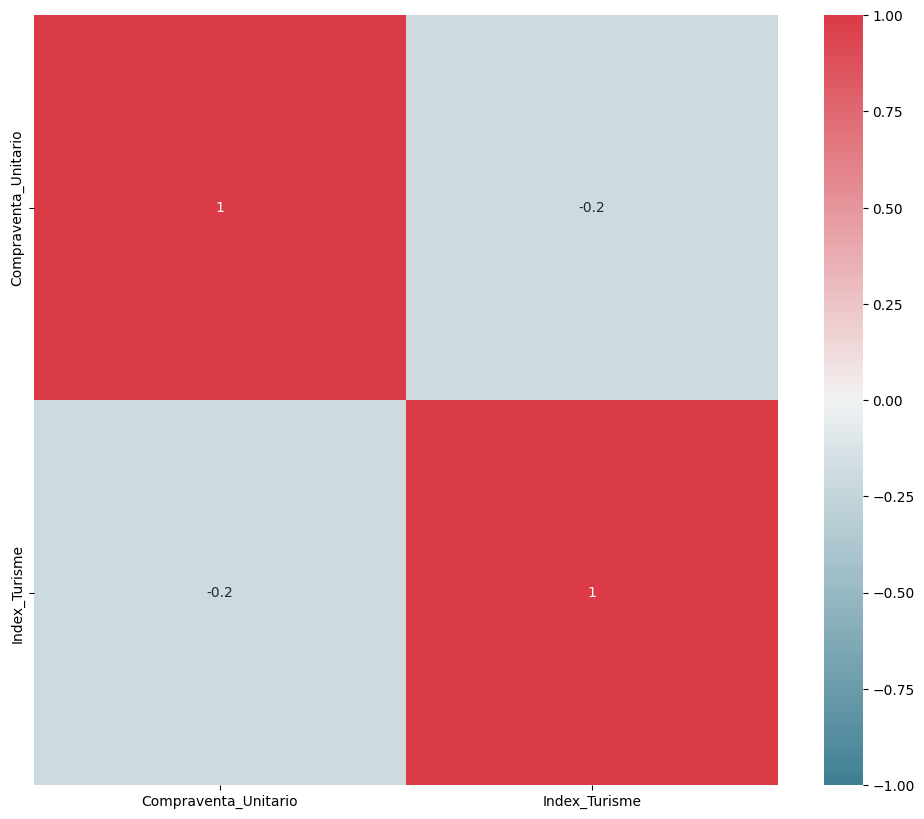

In [15]:
import seaborn as sb
fig, ax = plt.subplots(figsize=(12, 10))

sb.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot=True,vmax=1, vmin=-1, cmap =sb.diverging_palette(220, 10, as_cmap=True),center=0,ax=ax )
plt.show()

La correlación entre "Compraventa_Unitario" e "Index_Turisme" es de -0.19876, lo que sugiere una correlación negativa débil entre estas dos variables en tus datos.

### Modelo VAR

El modelo VAR es una extension del modelo ARIMA para multiples series temporales, es decir en vez de modelar una sola srie temporal, el VAR modela simultaneamente todas las series temporales de un sistema.
Cada serie temporal se regresa en función de usus propios valores pasados y de los valores pasados de las otras series temporales.
**Es util cuando las diferentes series temporales estan interrelacionadas y se influyen mutuamente.**




##### Dividir los datos en conjunto de Entrenamiento y Prueba


El modelo VAR se ajustará al conjunto de entrenamiento X_train y luego se utilizará el modelo para pronosticar las observaciones futuras. Estos pronósticos se compararán con los datos reales del conjunto de prueba.



---



In [16]:
fecha_division = '2021-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)


(24, 2) (12, 2)


##### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [17]:
import statsmodels.tsa.stattools as sts

In [18]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.928219
Serie de tiempo Index_Turisme
p-value: 0.769135


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [19]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Index_Turisme
Fecha,,
2019-02-01,0.000000,0.0
2019-03-01,0.000000,0.0
2019-04-01,-96.953846,0.0
2019-05-01,0.000000,0.0
2019-06-01,0.000000,0.0


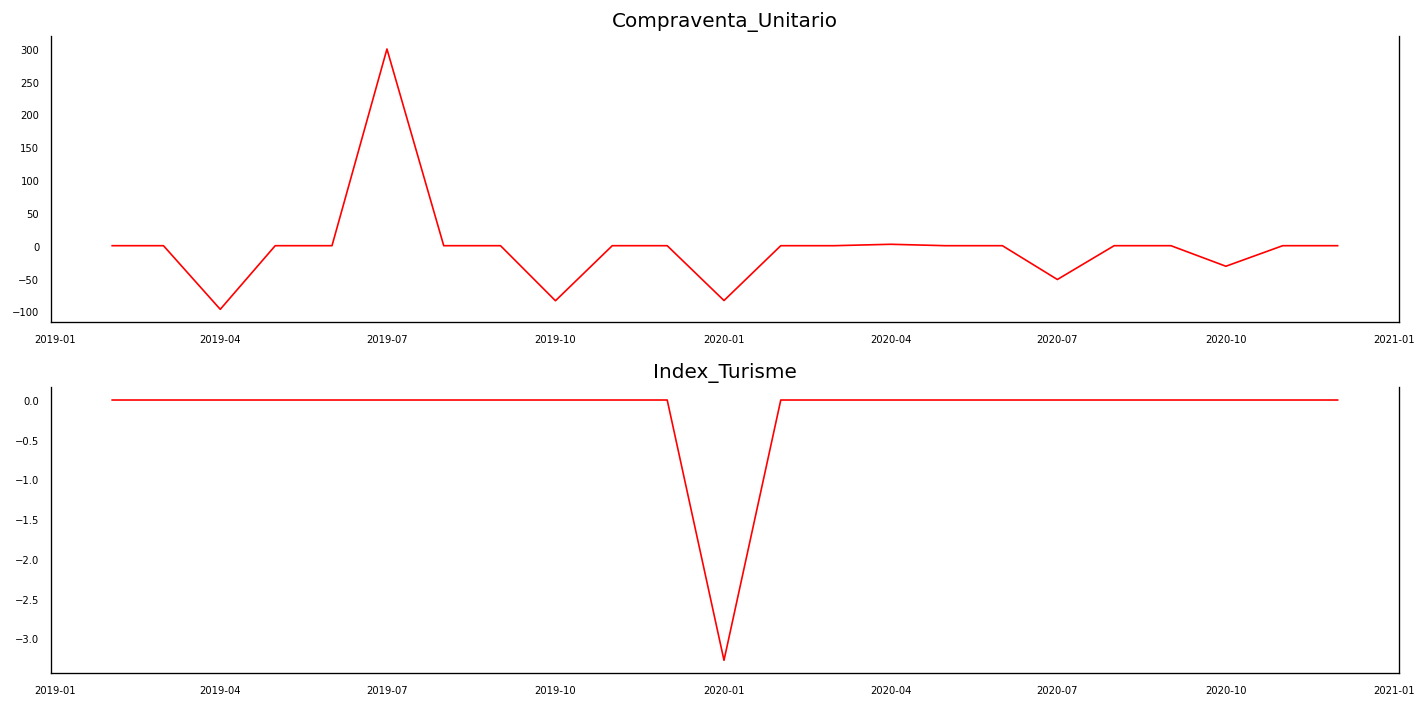

In [20]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [21]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.622302
Serie de tiempo transformada Variable Index_Turisme
p-value: 0.000088


In [22]:
#Diferenciando por segunda vez
X_train_transformed=X_train.diff().diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Index_Turisme
Fecha,,
2019-03-01,0.000000,0.0
2019-04-01,-96.953846,0.0
2019-05-01,96.953846,0.0
2019-06-01,0.000000,0.0
2019-07-01,299.723077,0.0


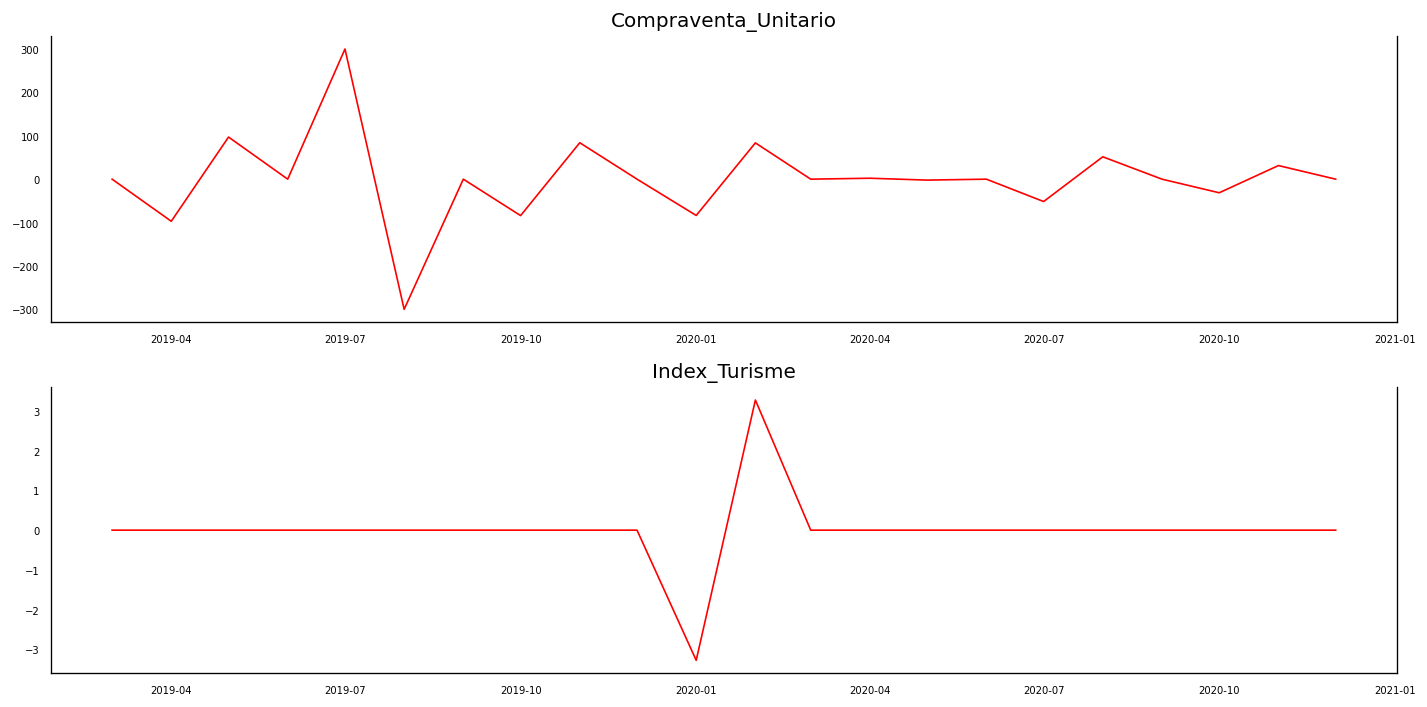

In [23]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=1, dpi=120, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    data = X_train_transformed[X_train_transformed.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(X_train_transformed.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [24]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Index_Turisme
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

In [25]:
from statsmodels.tsa.api import VAR

In [26]:
model = VAR(X_train_transformed)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


#### Seleccionando el orden del modelo

In [33]:
modelsel=model.select_order(5)
modelsel.summary()

,AIC,BIC,FPE,HQIC
0,9.207,9.305,9966.,9.216
1,8.746,9.040,6333.,8.775
2,8.967,9.457,8125.,9.016
3,8.681,9.367,6533.,8.749
4,8.726,9.609,7832.,8.814
5,6.064*,7.142*,704.1*,6.171*


#### Ajustando el modelo

In [32]:
res = model.fit(maxlags=5, ic='aic')
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 11, May, 2024
Time:                     07:32:17
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    7.14248
Nobs:                     17.0000    HQIC:                   6.17138
Log likelihood:          -77.7896    FPE:                    704.055
AIC:                      6.06420    Det(Omega_mle):         259.531
--------------------------------------------------------------------
Results for equation Compraventa_Unitario
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                         -15.500811        15.171621           -1.022           0.307
L1.Compraventa_Unitario        -0.713246         0.199854           -3.569           0.000
L1.In

La correlación entre los residuos de "Compraventa_Unitario" y los residuos de "Index_Turisme" es de 0.939034, lo que sugiere una correlación positiva fuerte entre los residuos de estas dos variables en los datos.

In [34]:
X_train.columns

Index(['Compraventa_Unitario', 'Index_Turisme'], dtype='object')

###### Causalidad de Granger

In [35]:
grangercaus=res.test_causality(['Index_Turisme'],['Compraventa_Unitario'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
3.246,3.106,0.044,"(5, 12)"


In [36]:
grangercaus=res.test_causality(['Compraventa_Unitario'],['Index_Turisme'],kind='f')
grangercaus.summary()

Test statistic,Critical value,p-value,df
0.3271,3.106,0.887,"(5, 12)"


Como se puede observar, la causalidad de Granger nos indica que ninguna de las series temporales puede predecir la otra serie temporal

###### Matriz de causalidad de Granger


In [37]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
warnings.filterwarnings("ignore")
maxlag=6
test = 'ssr_chi2test'
def grangers_causality_matrix(X_train_transformed, variables, test = 'ssr_chi2test', verbose=False):
  dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
  for c in dataset.columns:
    for r in dataset.index:
      test_result = grangercausalitytests(X_train_transformed[[r,c]], maxlag=maxlag, verbose=False)
      p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
      if verbose:
        print(f'Y = {r}, X = {c}, P Values = {p_values}')
      min_p_value = np.min(p_values)
      dataset.loc[r,c] = min_p_value
  dataset.columns = [var + '_x' for var in variables]
  dataset.index = [var + '_y' for var in variables]
  return dataset
grangers_causality_matrix(X_train_transformed, variables = X_train_transformed.columns)

,Compraventa_Unitario_x,Index_Turisme_x
Compraventa_Unitario_y,1.0,0.0
Index_Turisme_y,0.0,1.0


Con esta matriz queda claro que la serie temporal de Compraventa_Unitario no causa ni es causada por la otra serie temporal de ParadosReg

###### Diagnosis del modelo


###### Residuos

In [38]:
residuals=res.resid

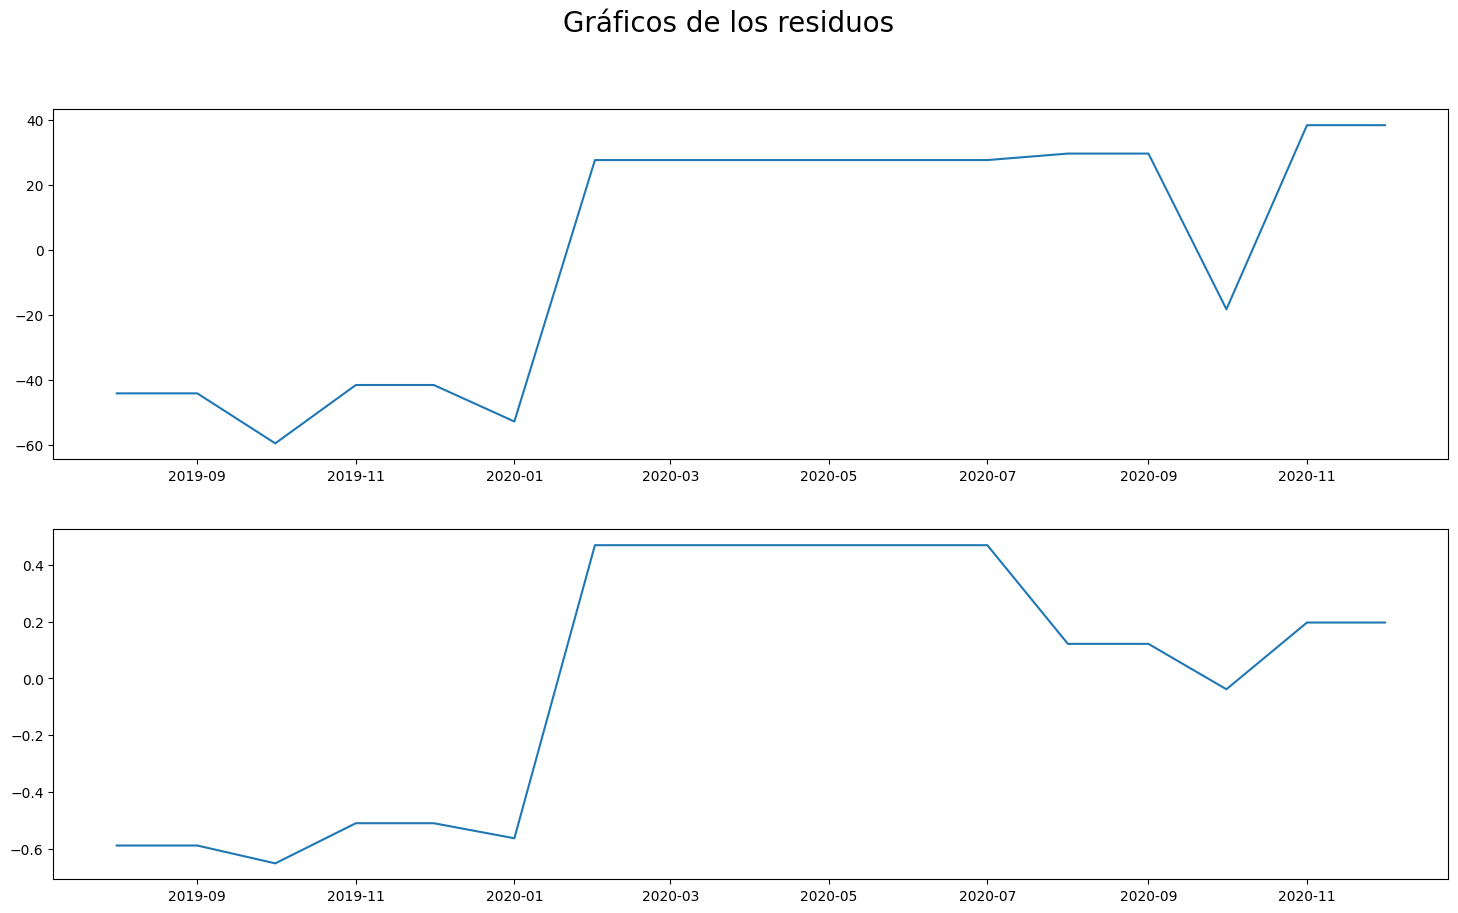

In [39]:
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los residuos',fontsize=20)
fig.set_size_inches(18, 10)
[axs[i].plot(residuals.iloc[:,i]) for i in range(2)]
plt.show()

###### Dickey - Fuller a los residuos


In [40]:
print('ADF de los Residuos, p-valores:')
[sts.adfuller(residuals.iloc[:,i])[1] for i in range(2)]

ADF de los Residuos, p-valores:


[0.48986279890228107, 1.0480745456700303e-19]

Todos los p-valores son < 0.1 por tanto se rechaza la hipótesis nula de que las 2 series de residuos no son estacionarias, por lo cual con un 90% de confianza se cree que son estacionarias.



###### ACF de los Residuos


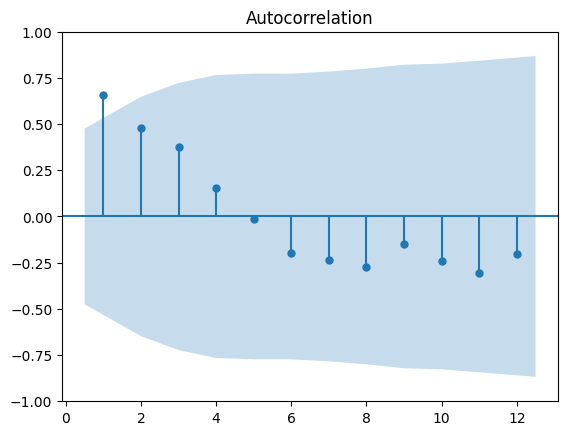

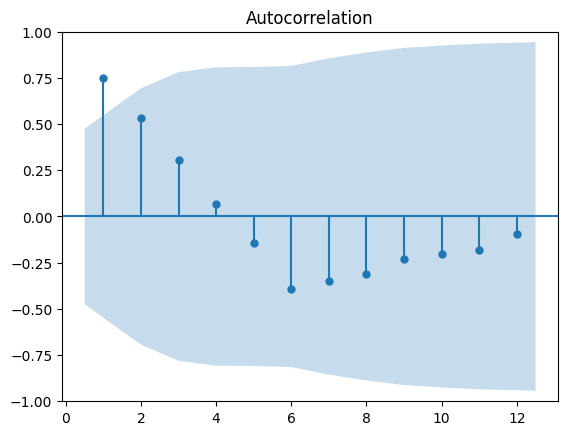

In [41]:
import statsmodels.graphics.tsaplots as sgt
[sgt.plot_acf(residuals.iloc[:,i], zero = False, lags = 12) for i in range(2)]
plt.show()

Conclusión: Los residuos del modelo no presentan estructura de autocorrelación, son estacionarios según los resultados de la prueba de Dickey - Fuller aumentada y en los gráficos se puede comprobar esto visualmente, entonces puede concluirse que son ruido blanco como es deseable.



#### Valores predichos


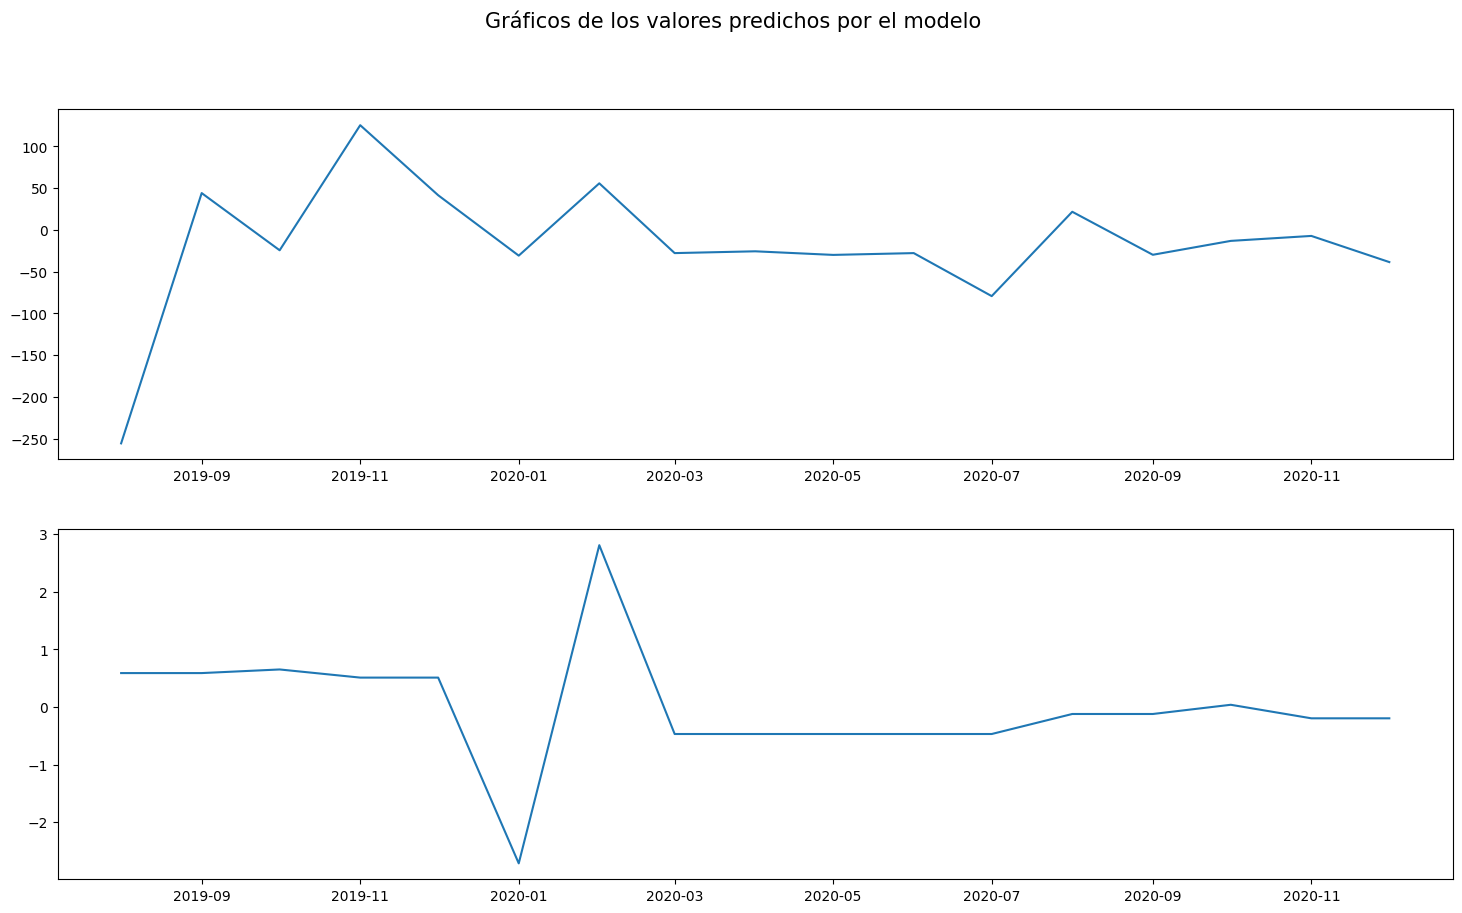

In [42]:
y_fitted = res.fittedvalues
fig, axs = plt.subplots(2)
fig.suptitle('Gráficos de los valores predichos por el modelo',fontsize=15)
fig.set_size_inches(18, 10)
[axs[i].plot(y_fitted.iloc[:,i]) for i in range(2)]
plt.show()

#### Pronósticos a futuro


Para pronosticar, al modelo VAR le podemos pasar hasta el número de orden de retraso de observaciones de los datos pasados. Esto se debe a que los términos en el modelo VAR son esencialmente los retrasos de las diversas series de tiempo en el conjunto de datos, por lo que debemos proporcionar tantos valores anteriores como lo indique el orden de retraso utilizado por el modelo. De lo contrario estaríamos introduciendo poca fiabilidad.



In [43]:
# Obtener el orden del modelo
lag_order = res.k_ar
print('Orden del modelo:', lag_order)
# Input data para hacer forecasting (pronósticos a futuro)
input_data = X_train_transformed.values[-lag_order:]
# Forecasting
pred = res.forecast(y=input_data, steps=12)
pred = (pd.DataFrame(pred, index=X_test.index, columns=X_test.columns + '_pred'))
print('Predicciones:')
pred

Orden del modelo: 5
Predicciones:


,Compraventa_Unitario_pred,Index_Turisme_pred
Fecha,,
2021-01-01,-10.585157,0.522036
2021-02-01,-21.929040,-0.605407
2021-03-01,-8.446006,-0.089256
2021-04-01,12.781513,0.498148
2021-05-01,-12.054367,-0.482663
2021-06-01,-8.620633,-0.112590
2021-07-01,8.216767,0.292696
2021-08-01,-15.676819,-0.166612
2021-09-01,-4.889146,-0.008757


<Figure size 1200x1000 with 0 Axes>

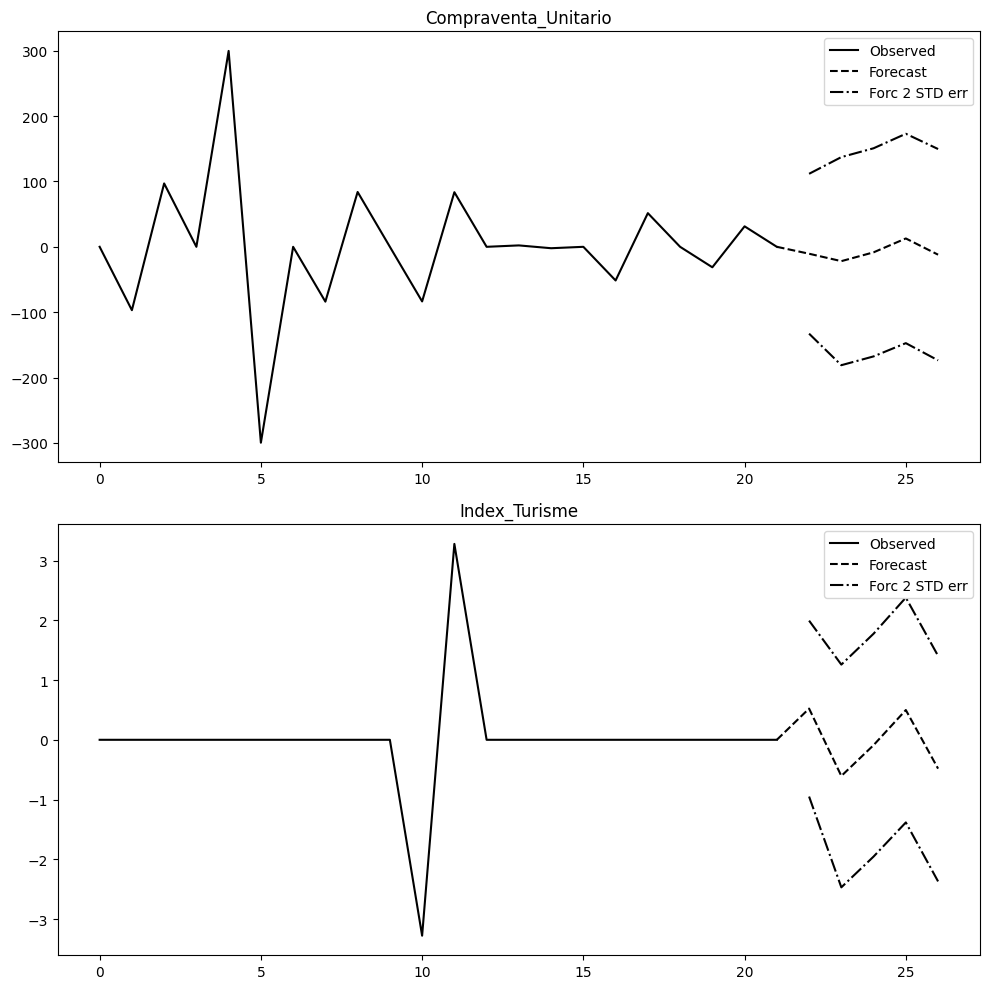

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 10))
res.plot_forecast(lag_order)
plt.tight_layout(h_pad = 1.15)
plt.show()


#### Invirtiendo la transformación de los pronósticos a la escala original


Los pronósticos se generan en la escala de los datos de entrenamiento utilizados por el modelo, es decir, son datos transformados. Entonces, para volver a ponerlos en su escala original, necesitamos des-diferenciarlos. La forma de invertir la diferenciación es sumar estas diferencias consecutivamente al número base. Una forma sencilla de hacerlo es determinar primero la suma acumulada y luego sumarla al número base. Este proceso se puede revertir agregando la observación en el paso de tiempo anterior al difference value. inverted(ts) = differenced(ts) + observation(ts-1)



In [45]:
# Invirtiendo la transformación teniendo en cuenta que hemos diferenciado dos veces
def invert_transformation(ds, df_forecast, second_diff=False):
    for col in ds.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (ds[col].iloc[-1] - ds[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = ds[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

In [46]:
pred.columns=X_test.columns
output = invert_transformation(X_train, pred, second_diff=True)
output

,Compraventa_Unitario,Index_Turisme
Fecha,,
2021-01-01,2186.499458,277.739627
2021-02-01,2153.985261,277.656255
2021-03-01,2113.025057,277.483627
2021-04-01,2084.846366,277.809147
2021-05-01,2044.613309,277.652004
2021-06-01,1995.759619,277.382271
2021-07-01,1955.122696,277.405235
2021-08-01,1898.808954,277.261586
2021-09-01,1837.606067,277.109181


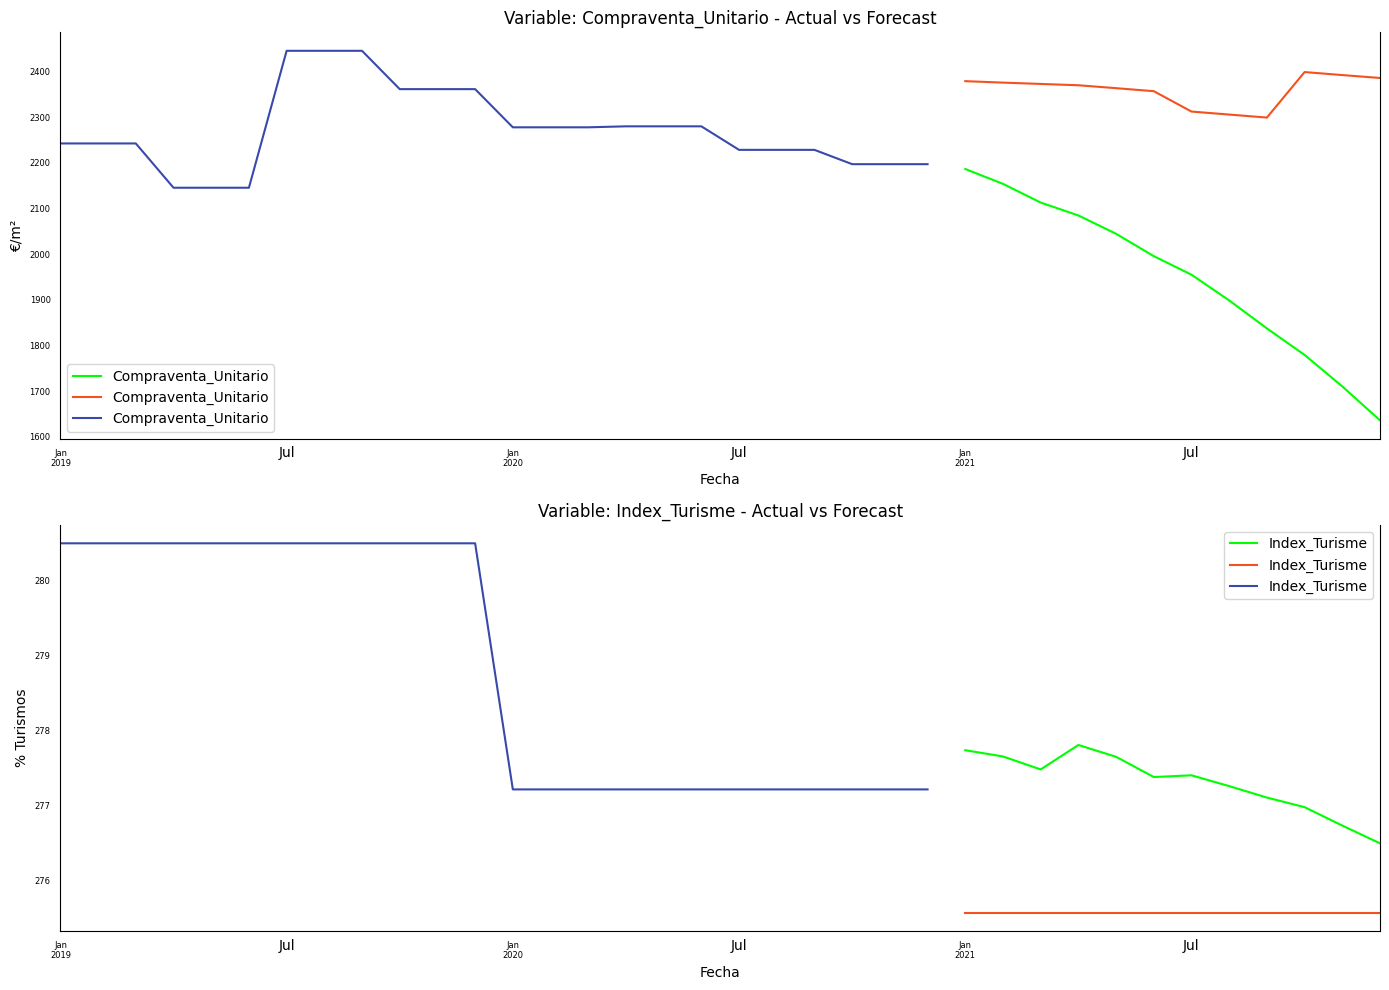

In [47]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Turismos']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    output[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo


In [48]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [49]:
for i in ['Compraventa_Unitario','Index_Turisme']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , output[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 198527.66009424606
MAE is : 409.5078138521185
RMSE is : 445.5644286680054
MAPE is : 17.33942185216451
R2 is : -182.2119174730522

Evaluation metric for Index_Turisme
Evaluation metric results:-
MSE is : 3.16844717997089
MAE is : 1.736112543361249
RMSE is : 1.780013252751476
MAPE is : 0.6299997948818835
R2 is : 0.0



Para "Compraventa_Unitario", el modelo muestra un rendimiento muy deficiente con un R2 negativo y un RMSE muy alto, lo que sugiere que el modelo no se ajusta bien a los datos y tiene dificultades para predecir "Compraventa_Unitario".

Para "Index_Turisme", el modelo parece tener un rendimiento aceptable con un R2 de 0, lo que indica que el modelo se ajusta bien a los datos para "Index_Turisme". Las métricas de error también son relativamente bajas, lo que sugiere que el modelo puede predecir efectivamente la variable "Index_Turisme".

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, output))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, output)))

Mean absolute error: 205.62196319773986
Root mean squared error: 315.06414310535723


### Modelo VARMAX (Auto Arima)

El modelo VARMAX es una extension del modelo VAR que permite incorporar variebles exogenas, es decir, varibales externas que pueden afectar a las series temporales del sistema, es decir, que ademas de modelar la dependencia entre las variables del sistema, el VARMAX tambien puede capturar la influencia de variables externas sobre las series temporales.

In [51]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.3 MB/s eta 0:00:00


#### Dividir los datos en conjuntos de Entrenamiento Y Prueba

In [52]:
fecha_division = '2021-01-01'

X_train, X_test = df[df.index<fecha_division], df[df.index>=fecha_division]
print(X_train.shape, X_test.shape)

(24, 2) (12, 2)


#### Prueba de estacionariedad

Necesitamos que los datos sean estacionarios para poder usar el modelo VAR. Vamos a averiguarlo haciendo un Test de Dickey-Fuller aumentado, a cada variable univariante que tiene nuestro dataset.

In [53]:
def augmented_dickey_fuller_statistics(time_series):
  result = sts.adfuller(time_series.values)
  print('p-value: %f' % result[1])

print('Test de Dickey-Fuller Aumentado:')
for i in range(len(X_train.columns)):
  print('Serie de tiempo',X_train.columns[i])
  augmented_dickey_fuller_statistics(X_train.iloc[:,i])

Test de Dickey-Fuller Aumentado:
Serie de tiempo Compraventa_Unitario
p-value: 0.928219
Serie de tiempo Index_Turisme
p-value: 0.769135


Los p-valores son mayores que 0.05, con lo cual no se rechaza la hipótesis nula de que la serie no es estacionaria. Habría que transformar los datos porque no se puede confirmar estacionariedad.

In [54]:
#Diferenciando por primera vez
X_train_transformed=X_train.diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Index_Turisme
Fecha,,
2019-02-01,0.000000,0.0
2019-03-01,0.000000,0.0
2019-04-01,-96.953846,0.0
2019-05-01,0.000000,0.0
2019-06-01,0.000000,0.0


In [55]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.622302
Serie de tiempo transformada Variable Index_Turisme
p-value: 0.000088


In [56]:
#Diferenciando por segunda vez
X_train_transformed=X_train.diff().diff().dropna()
X_train_transformed.head()

,Compraventa_Unitario,Index_Turisme
Fecha,,
2019-03-01,0.000000,0.0
2019-04-01,-96.953846,0.0
2019-05-01,96.953846,0.0
2019-06-01,0.000000,0.0
2019-07-01,299.723077,0.0


In [57]:
print('Test de Dickey-Fuller Aumentado 2da vez:')
for i in range(len(X_train_transformed.columns)):
  print('Serie de tiempo transformada', 'Variable', X_train_transformed.columns[i])
  augmented_dickey_fuller_statistics(X_train_transformed.iloc[:,i])

Test de Dickey-Fuller Aumentado 2da vez:
Serie de tiempo transformada Variable Compraventa_Unitario
p-value: 0.000000
Serie de tiempo transformada Variable Index_Turisme
p-value: 0.000000


Todos los p-valores son < 0.05 por lo tanto se podría concluir que con 2 ordenes de diferenciación se obtienen series estacionarias.

####Test de Cointegracion

Determinaremos si las dos variables estan relacionadas entre si y si esa relacion es duradera o no

In [58]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df):
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6):
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [ ]:
cointegration_test(X_train_transformed[['Compraventa_Unitario','Index_Turisme']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Compraventa_Unitario >  580.51    > 12.3212   =>   True
Index_Turisme >  3.81      > 4.1296    =>   False


Para la variable "Compraventa_Unitario": El valor del estadístico de prueba es 580.51, que supera significativamente el valor crítico de 12.3212 para un nivel de significancia del 95%. Esto indica que existe una relación de causalidad significativa entre "Compraventa_Unitario" y "Index_Turisme".

Para la variable "Index_Turisme": El valor del estadístico de prueba es 3.81, que es menor que el valor crítico de 4.1296 para un nivel de significancia del 95%. Por lo tanto, no hay suficiente evidencia para rechazar la hipótesis nula de que "Index_Turisme" no causa Granger a "Compraventa_Unitario".

#### Ajustando el modelo

#####Auto Arima

Aplicaremos autoarima, para determinar los valores de p, q y d

In [59]:
import pmdarima as pm

In [60]:

pq = []
for name in ['Compraventa_Unitario', 'Index_Turisme']:
    print(f'Searching order of p and q for : {name}')
    # Ajusta un modelo ARIMA para cada columna
    stepwise_model = pm.auto_arima(X_train_transformed[name],
                                start_p=0, start_q=0,
                                max_p=4, max_q=4,
                                seasonal=False,
                                trace=True,
                                error_action='ignore',
                                suppress_warnings=True,
                                stepwise=True,
                                maxiter=1000)
    # Obtiene los parámetros óptimos de p y q del modelo
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    # Agrega los parámetros óptimos a la lista pq
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : Compraventa_Unitario
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=268.398, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=264.343, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=266.234, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=266.343, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0]          
Total fit time: 0.465 seconds
optimal order for:Compraventa_Unitario is: (1, 0, 0) 


Searching order of p and q for : Index_Turisme
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=63.915, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=59.859, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=59.490

#####Seleccion del modelo

In [61]:
def inverse_diff(actual_df, pred_df, second_diff=False):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        if second_diff:
          df_res[str(col)] = (actual_df[col].iloc[-1]- actual_df[col].iloc[-2]) + df_res[str(col)].cumsum()

        df_res[str(col)] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [62]:
pq

[(1, 0, 0), (2, 0, 0)]

Para la serie temporal de compraventa unitario

- *p=1:* Indica que se incluye un término autoregresivo de primer orden para esta variable en el modelo, es decir, se considera la dependencia de la variable respecto a su propio valor en el periodo anterior.

- *q=0:* Indica que no se incluyen términos de medias móviles para esta variable en el modelo, lo que significa que no se considera la dependencia de los errores pasados de esta variable en sí misma.

Para la serie temporal de motorizacion turisme

- *p=2:* Indica que se incluyen términos autoregresivos hasta el segundo orden para esta variable en el modelo, es decir, se considera la dependencia de la variable respecto a sus valores en los dos periodos anteriores.

- *q=0:* Indica que no se incluyen términos de medias móviles para esta variable en el modelo, lo que significa que no se considera la dependencia de los errores pasados de esta variable en sí misma.

In [63]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [64]:
df_results_moni = pd.DataFrame(columns=['p', 'q','RMSE Compraventa_Unitario','RMSE Index_Turisme'])
print('Grid Search Started')
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(X_train_transformed[['Compraventa_Unitario', 'Index_Turisme']], order=(i[0],i[2])).fit( disp=False)
        result = model.forecast(steps = 12)
        inv_res = inverse_diff(df[['Compraventa_Unitario', 'Index_Turisme']] , result, True)
        Comprarmse = np.sqrt(metrics.mean_squared_error(X_test['Compraventa_Unitario'], inv_res.Compraventa_Unitario))
        Paradosrmse = np.sqrt(metrics.mean_squared_error(X_test['Index_Turisme'], inv_res.Index_Turisme))
        #df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'RMSE Compraventa_Unitario':Comprarmse,'RMSE ParadosReg':Paradosrmse }, ignore_index=False)
        df_results_moni.loc[len(df_results_moni)] = [i[0], i[2], Comprarmse, Paradosrmse]


Grid Search Started
 Running for (1, 0, 0)
 Running for (2, 0, 0)


In [65]:
df_results_moni.sort_values(by = ['RMSE Compraventa_Unitario','RMSE Index_Turisme'] )

,p,q,RMSE Compraventa_Unitario,RMSE Index_Turisme
0,1.0,0.0,41.286142,0.000220
1,2.0,0.0,46.043282,0.250446


#### Pronósticos a futuro


In [66]:
model = VARMAX(X_train_transformed[['Compraventa_Unitario','Index_Turisme',]], order=(0,2)).fit(disp=False)
result = model.forecast(steps = 12)

In [ ]:
result

,Compraventa_Unitario,Index_Turisme
2021-01-01,-12.898448,-0.144317
2021-02-01,-2.610211,-0.018284
2021-03-01,-0.023787,0.001051
2021-04-01,-0.023787,0.001051
2021-05-01,-0.023787,0.001051
2021-06-01,-0.023787,0.001051
2021-07-01,-0.023787,0.001051
2021-08-01,-0.023787,0.001051
2021-09-01,-0.023787,0.001051
2021-10-01,-0.023787,0.001051


#### Invertiendo la transformacion de los pronosticos a la escala original

In [67]:
res = inverse_diff(df[['Compraventa_Unitario', 'Index_Turisme']],result,True)

In [68]:
res

,Compraventa_Unitario,Index_Turisme
2021-01-01,2366.467230,275.429193
2021-02-01,2344.580439,275.266592
2021-03-01,2322.669861,275.105042
2021-04-01,2300.735496,274.944544
2021-05-01,2278.777344,274.785096
2021-06-01,2256.795405,274.626700
2021-07-01,2234.789679,274.469354
2021-08-01,2212.760166,274.313060
2021-09-01,2190.706867,274.157817
2021-10-01,2168.629780,274.003625


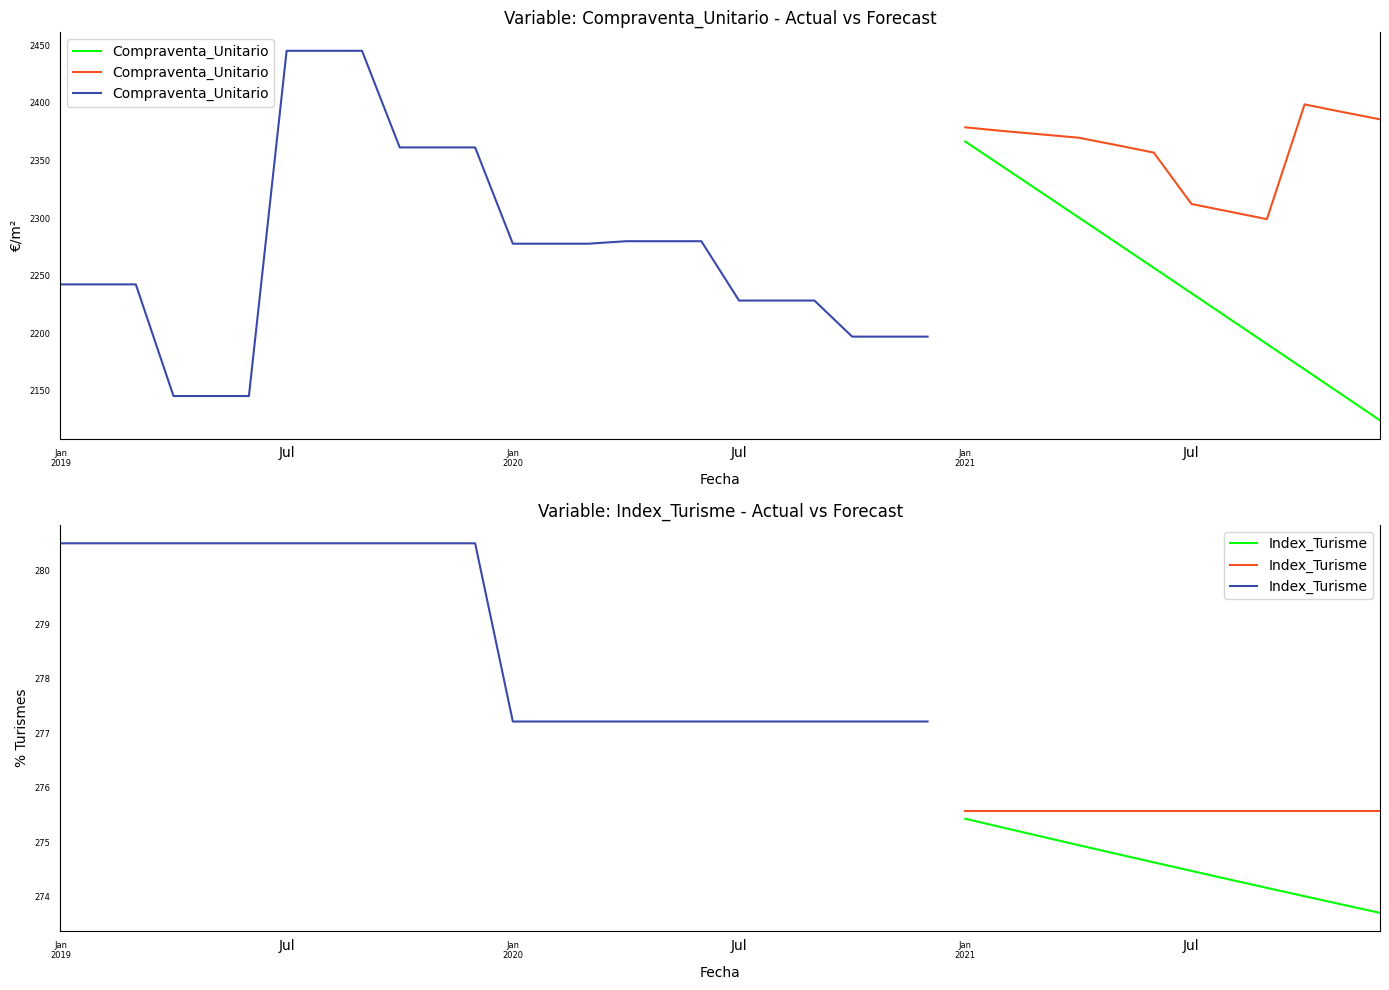

In [69]:
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(X_train.columns)), ncols = 1, dpi = 100, figsize = (14,10))
mi_lista = ['€/m²', '% Turismes']

for i, (col,ax) in enumerate(zip(X_train.columns, axes.flatten())):
    res[col].plot(color = '#00FF00', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    X_test[col].plot(color = '#F4511E', legend = True, ax = ax)
    X_train[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Variable: ' + col + ' - Actual vs Forecast')
    ax.set_ylabel(mi_lista[i])  # Establecer etiqueta del eje y
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

#### Evaluando el modelo

In [70]:
def timeseries_evaluation_metrics_func(y_true, y_pred):

    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [71]:
for i in ['Compraventa_Unitario','Index_Turisme']:
    print(f'Evaluation metric for {i}')
    timeseries_evaluation_metrics_func(X_test[str(i)] , res[str(i)])

Evaluation metric for Compraventa_Unitario
Evaluation metric results:-
MSE is : 19458.239418752306
MAE is : 113.57877159863934
RMSE is : 139.49279342945394
MAPE is : 4.798482350508619
R2 is : -16.957101558880776

Evaluation metric for Index_Turisme
Evaluation metric results:-
MSE is : 1.334134354276847
MAE is : 1.0193508764970762
RMSE is : 1.1550473385436837
MAPE is : 0.36990162046896746
R2 is : 0.0



Para "Compraventa_Unitario", el MSE y el RMSE son bastante altos, lo que sugiere que las predicciones están bastante alejadas de los valores reales. El MAE y el MAPE son relativamente altos también. Además, el R2 negativo indica que el modelo no se ajusta bien a los datos.

Para "Index_Turisme", las métricas son mejores en comparación. El MSE, el MAE y el RMSE son bajos, lo que sugiere una mejor precisión en las predicciones. El MAPE también es bajo, indicando un buen ajuste relativo, y el R2 de 0.0 indica un ajuste aceptable del modelo.

In [72]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('Mean absolute error:', mean_absolute_error(X_test, res))
print('Root mean squared error:', np.sqrt(mean_squared_error(X_test, res)))

Mean absolute error: 57.2990612375682
Root mean squared error: 98.63968155135788


##Conclusiones

Como conclusiones de realizar un analisis de datos forecasting a los datos de distrito de **Nou Barris** de Barcelona entre las dos series temporales de Compraventa_unitario y indice de motorizacion de turismos, tenemos que:

- Se ha comprobado que las variables tienen una baja correlacion inversa.
- Se ha comprobado que la dos series de datos temporales tienen estacionalidad a partir del segundo orden de diferenciacion, lo que las hace aptas para aplicar los dos modelos VAR y VARMAX .
- En el modelo VAR se ha comprobado la causalidad de Granger, y esta ha salido negativa, lo que quiere decir que ninguna serie temporal puede causar las demas series temporales. Esto en un principio nos advierte que este modelo sera más aconsejable que el modelo VARMAX
- El test de cointegracion en el modelo VARMAX nos ha dado negativo, lo que significa que las series no estan relacionadas en el tiempo y que con estos seria mas adecuado un modelo VAR

Como hemos visto, los modelos obtenidos no se ajustan a los datos de test, dado que las series temporales no cumplen varias limitaciones de los modelos a aplicar. Fruto de ellos son modelos con limitaciones en la capacidad predictiva, y modelado incorrecto de la relacion entre ellas.  

